In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.optimize import minimize
from scipy.optimize import leastsq
import pandas as pd

plt.ion()

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [2]:
B20 = -2.773e-2
B40 = -3.987e-4
B43 = -1.416e-2
B60 = 3.152e-6
B63 = -7.616e-6
B66 = 3.275e-5

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K];
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

In [3]:
# okay, so next step is import the data and do a ZF subtraction
fname = '/Users/hopeless/Desktop/LeeLab/data/Maglab_IRMeasurement_June2022/ProcessingCode/Load1_TrimData/P2_CsEr_100-FIR_RAWAVG.dat'


rawData = pd.read_csv(fname, index_col=0, skiprows=0, header=1)
normDataB = rawData.dropna(axis = 0)
# normDataB = normDataB.iloc[0:4000, :]
normDataB = normDataB.dropna(axis=1)
normDataB = normDataB.drop(labels = '-1.1', axis=1)

In [4]:
# pandas dataframes seem useful, worth learning
# let's use it!!
# rawData.columns
# rawData.index
# okay so now let's quickly normalize. This would be way easier if I could just load the already normalized data from matlab :(

normSpec = rawData['0.001']/max(rawData['0.001'])
avgSpec = normSpec
for column in normDataB.columns: 
    # in a dataframe, column is a key
    normDataB[column] = max(normDataB[column]) -normDataB[column]
    normDataB[column] = normDataB[column]/(max(normDataB[column])) -normSpec
    avgSpec = avgSpec + normDataB[column]

# len(rawData.columns)
# for column in normData.columns: 
#     normData[column] = normData[column]-avgSpec/len(rawData.columns)

In [5]:
len(rawData.columns)
for column in normDataB.columns: 
    normDataB[column] = normDataB[column]-avgSpec/len(rawData.columns)
    normDataB[column] = normDataB[column]-(sum(normDataB[column])/len(normDataB[column]))
    # normDataB[column] = normDataB[column]-min(normDataB[column]) #brings min to 0
    # normDataB[column] = normDataB[column]/max(normDataB[column]+0.01)+0.01
normDataB = normDataB.drop(labels='0.001', axis=1)
fullData = normDataB
normDataB = normDataB.drop(labels=['0.25'], axis=1)

In [269]:
# normDataB = fullData
# normDataB = normDataB.drop(labels=['0.25','0.5', '0.75', '0.999', '1.249', '1.499', '1.749', '2', '2.5','3', '3.5', '3.999', '4.5', '5', '5.5', '5.999', '6.499', '7', '7.5'], axis=1)
normDataB.index

Float64Index([8.3772, 8.4073, 8.4375, 8.4676, 8.4977, 8.5279,  8.558, 8.5881,
              8.6183, 8.6484,
              ...
              719.69, 719.72, 719.75, 719.78, 719.81, 719.84, 719.87,  719.9,
              719.93, 719.96],
             dtype='float64', name='-1', length=23592)

In [280]:
for index in normDataB.index:
    if index>120:
        normDataB = normDataB.drop(labels=index , axis = 0)

In [368]:
# lets get bfield + wavenum arrays from the dataframe
i = 0
Bfield = []
for column in normDataB.columns: 
    Bfield.append(float(normDataB.columns[i]))
    i +=1

i = 0
wavenums = []
for index in normDataB.index: 
    wavenums.append(float(normDataB.index[i]))
    i+=1

wavenums = np.array(wavenums)


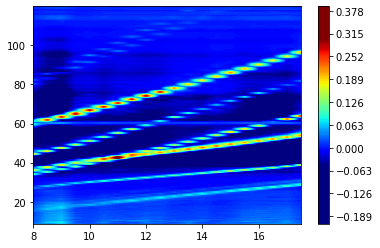

In [282]:
plt.ion()
plt.contourf(Bfield, wavenums, normDataB, 200, cmap = 'jet')

plt.clim(-0.05,.3)
plt.colorbar()


# okay, so now we have our data in a pandas dataframe
so now we want to make our calculated data into a dataframe
 lets first redefine the dummy model
 TO DO: build this into pycrystalfield

In [296]:

def zeemanSplitLines(ionObj, ion, Field): 
    # ion input is cef.CFLevels.Bdict(ion,Bparams) type of variable
    # magnetic hamiltonian -> here we are using a magnetic dipole in a uniform, static field
    # this gives potential V = -mu.B
    # for our electrons, we can rewrite mu = gumBJ, with some prefactor
    # here J is our total ang mom. J = L+S

    
    JdotB = muB*(Field[0]*cef.Operator.Jx(ionObj.J) + Field[1]*cef.Operator.Jy(ionObj.J) + Field[2]*cef.Operator.Jz(ionObj.J))*cef.LandeGFactor(ion)
    #we've defined this as a CFLevels object

    # define just the CEF hamiltonian
    # H = ionObj.H # this is built into the CFLevels class. see pycrystal field doc
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    # its just a sum of the stevens operators and the corresponding params
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag

    # I don't think we need this return statement. diagonalize 
    # already stores these vals in the object
    return ionObj.eigenvalues 



def calculateZeemanSpec(ionObj,ion, Bfield): 
    # actually calculate your splitting for a giving field in 3d
    calcA = []
    calcB = [] 
    calcC = []
    for B in Bfield: 
        calcA.append(zeemanSplit(ionObj, ion, [B, 0, 0])*meVToCm)
        calcB.append(zeemanSplit(ionObj, ion, [0, B, 0])*meVToCm)
        calcC.append(zeemanSplit(ionObj, ion, [0, 0, B])*meVToCm)
    calcA = np.array(calcA)
    calcB = np.array(calcB)
    calcC = np.array(calcC)
    return calcA, calcB, calcC

def dummyModelB(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield)
    # I still don't understand why its just calcA... figure this out...
    return calcB.T

def make2dCalcB(params): 
    # want to feed field, wave and then return calculated value
    
    #initialize dataframe with every value as the min of our nomralized data
    calcData = pd.DataFrame(0.01, index= normDataB.index, columns=normDataB.columns)
    B20, B40, B43, B60, B63, B66 = params
    calcLines = dummyModelB(B20, B40, B43, B60, B63, B66)
    for k in range(len(calcLines)): 
        #loop through each line
        j=0
        for column in calcData: 
            index = (np.abs(wavenums-(calcLines[k][j])).argmin()) 
            calcData.iat[index,j] =1.
            if index<(len(normDataB.index)-10):
                calcData.iat[index+1,j] =.9
                calcData.iat[index+2,j] =.8
                calcData.iat[index+3,j] =.7
                calcData.iat[index+4,j] =.6
                calcData.iat[index+5,j] =.5
            if index>6:
                calcData.iat[index-1,j] =.9
                calcData.iat[index-2,j] =.8            
                calcData.iat[index-3,j] =.7
                calcData.iat[index-4,j] =.6
                calcData.iat[index-5,j] =.5

            j+=1
    return calcData

    
# def residual2d(params): 

In [297]:
params = [B20, B40, B43, B60, B63, B66]
calcDataGuess = make2dCalcB(params)
# calcA = dummyModel(B20, B40, B43, B60, B63, B66)

(0.0, 126.0)

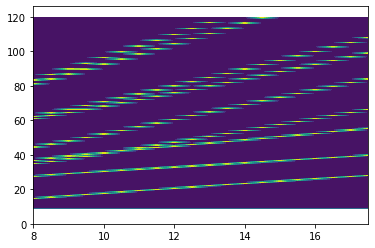

In [298]:
plt.ion()
plt.contourf(Bfield, wavenums, calcDataGuess, 10)
plt.ylim(0,126)

# PERFECT!!
# not really but thats fine :) 
# okay, so now we make a GOF fun that will subtract pixel by pixel 


In [299]:
def residualB(params): 
    chi2 = 0
    calcData= make2dCalcB(params)
    temp = (calcData-normDataB)**2/calcData
    chi2 = temp.values.sum()
    return chi2

In [300]:
chi2 = residualB(params)
chi2

23248.966488617392

starting guess params from https://journals.aps.org/prb/pdf/10.1103/PhysRevB.101.144432

In [301]:

B20 = -3.559e-2
B40 = -3.849e-4
B43 = -1.393e-2
B60 = 3.154e-6
B63 = -4.695e-6
B66 = 3.381e-5

guess = [B20, B40, B43, B60, B63, B66] 
guessLinesB = dummyModelB(B20, B40, B43, B60, B63, B66)
resultB = minimize(funToMinB, guess, method ='L-BFGS-B',
        options={'disp': True, 'maxiter':2000}, 
        # callback('intermediate_result': OptimizeResult),  
        # full_output=True, 
        # retall=False)
                 )


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32490D+04    |proj g|=  2.43835D+09

At iterate    1    f=  2.23498D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     10      1     0     0   0.000D+00   2.235D+04
  F =   22349.757219019095     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [302]:
resultB

      fun: 22349.757219019095
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 70
      nit: 1
     njev: 10
   status: 0
  success: True
        x: array([-3.55900000e-02, -3.81559638e-04, -1.39304621e-02,  1.49364950e-04,
       -4.19129594e-05,  3.74135972e-05])

In [303]:
resultB.x

array([-3.55900000e-02, -3.81559638e-04, -1.39304621e-02,  1.49364950e-04,
       -4.19129594e-05,  3.74135972e-05])

In [378]:
calcLinesB = dummyModelB(resultB.x[0], resultB.x[1], resultB.x[2], resultB.x[3], resultB.x[4], resultB.x[5])
paramsB = [resultB.x[0], resultB.x[1], resultB.x[2], resultB.x[3], resultB.x[4], resultB.x[5]]
newCalcDataB = make2dCalcB(paramsB)
guessLinesB = dummyModelB(B20, B40, B43, B60, B63, B66)


TypeError: zeemanSplit() missing 5 required positional arguments: 'B40', 'B43', 'B60', 'B63', and 'B66'

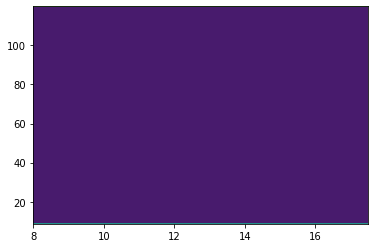

In [305]:
plt.ion()
# plt.contour(Bfield, wavenums, newCalcData, 10)
# plt.ylim(0,10)
# plt.contourf(Bfield, wavenums, normData,100)
plt.contourf(Bfield, wavenums, newCalcDataB, 8)

In [306]:
def plotCalcZSpec(calcArr, Bfield): 
    plt.ion()
    for i in range(len(calcArr)):
        plt.plot( calcArr[i],Bfield,  'r', linestyle = '-', marker = ' ') 
    return

Text(0.5, 1.0, 'CsErSe2 w/overlayed calculated CEF Lines')

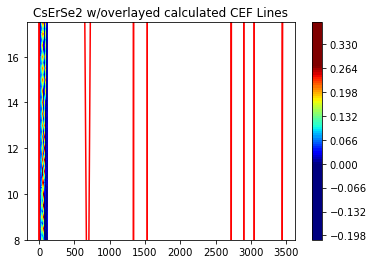

In [307]:

plt.contourf( wavenums, Bfield,normDataB.T,100, cmap ='jet')
plotCalcZSpec(calcLinesB, Bfield)
# plt.ylim(0,17)
# plt.xlim(0,120)
plt.clim(0,.27)
plt.colorbar()
plt.title('CsErSe2 w/overlayed calculated CEF Lines')

Text(0.5, 1.0, 'CsErSe2 w/overlayed guess CEF Lines')

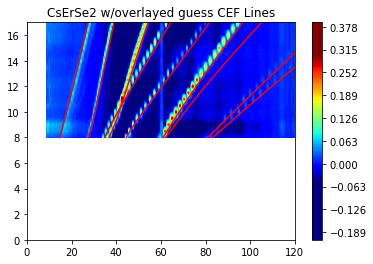

In [308]:
plt.contourf( wavenums, Bfield,normDataB.T,200, cmap ='jet')
plotCalcZSpec(guessLinesB, Bfield)
plt.ylim(0,17)
plt.xlim(0,120)
plt.clim(-0.05,.3)
plt.colorbar()
plt.title('CsErSe2 w/overlayed guess CEF Lines')

# Lets try this with lmfit again

In [363]:
# let's try this with least squares minimization

y = wavenums
x = Bfield
z = normDataB.to_numpy()[1:,1:]
ion = 'Er3+'
B20 = -3.559e-2
B40 = -3.849e-4
B43 = -1.393e-2
B60 = 3.154e-6
B63 = -4.695e-6
B66 = 3.381e-5
# params = [B20, B40, B43, V60, B63, B66]
# lets rewrite the dummyModel to output Z vals for given x, y
def gaussian(x, amp,cen , wid):
    return amp * np.exp(-(x-cen)**2 / wid)

def diagonalize(ionObj, ion, Field): 
    JdotB = muB*(Field*cef.Operator.Jy(ionObj.J))*cef.LandeGFactor(ion)
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 



def zeemanSplit(x, y, B20, B40, B43, B60, B63, B66):     
    # assuming only H||B rn
    # assuming that x is an array
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    evals = diagonalize(ionObj, ion, x)
    centers = evals*meVToCm
    # so now we want to create a multi gaussian with centers at the eigenvalues
    amp = 1
    wid = 1 # pulled this out my ass, .5cm-1 resolution roughly
    fun = gaussian(y, amp, centers[0], wid)
    for i in range(len(centers[1:])):
        fun += gaussian(y, amp, centers[i], wid)
    return fun



In [ ]:
# let's take a second and see if we can't fix the operator issue 

Text(0.5, 1.0, 'CsErSe2 H||b real data')

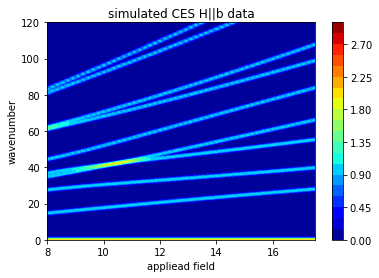

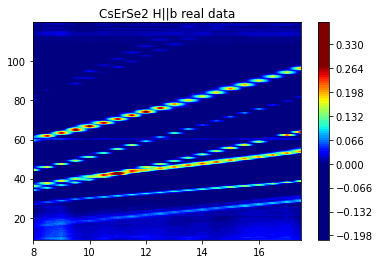

In [371]:

amp = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# plt.plot(y, tempY)
def fun(x, y, B20, B40, B43, B60, B63, B66):
    arr = []
    for field in x: 
        arr.append(zeemanSplit(field, y, B20, B40, B43, B60, B63, B66))
    return arr
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)
arr = fun(fieldArr, waveArr,B20, B40, B43, B60, B63, B66) 
arr = np.array(arr)
 
plt.contourf(fieldArr,waveArr,arr.T, 20, cmap='jet')
plt.xlim(8,17.5)
plt.ylim(0,120)
plt.title('simulated CES H||b data')
plt.xlabel('appliead field')
plt.ylabel('wavenumber')
plt.colorbar()

plt.figure()
plt.contourf(Bfield, wavenums, normDataB,100, cmap ='jet')
# plt.xlim(0,17.5)
# plt.ylim(0,120)
plt.clim(0,.27)
plt.colorbar()
plt.title('CsErSe2 H||b real data')

In [149]:
tempZ

# lmfit modelling does not work do not use

In [150]:
# model = lmfit.Model(fun, independent_vars=['x', 'y'])
# params = model.make_params()
# params['B20'].set(value= -3.559e-2)
# params['B40'].set(value= -3.849e-4)
# params['B43'].set(value= -1.393e-2)
# params['B60'].set(value= 3.154e-6)
# params['B63'].set(value= -4.695e-6)
# params['B66'].set(value= 3.381e-5)
# result = model.fit(z, x=x, y=y, params =params, nan_policy = 'ignore')

In [372]:
# okay, so now lets write a custom leastsq min 
# lets write a residual function

def residual(params): 
    # assume we already have wavenums & Bfield
    # not great but whatever lets go
    bg= 0.01
    calcData = np.array(fun(Bfield, wavenums, params[0], params[1],params[2],params[3],params[4],params[5]))
    calcData = pd.DataFrame(calcData.T+bg, index= normDataB.index, columns=normDataB.columns)
    temp = (normDataB-calcData)**2/calcData
    chi2 = temp.values.sum()
    return chi2


In [373]:
params =  [B20, B40, B43, B60, B63, B66]

chi2 = residual(params)

# okay, so now we do the same minimization as before

result = minimize(residual, params)

In [376]:
print(result.x)
print(params)

[-3.55915967e-02 -4.46392102e-04 -1.39193134e-02 -4.09961599e-03
 -6.43538749e-04 -8.63019598e-05]
[-0.03559, -0.0003849, -0.01393, 3.154e-06, -4.695e-06, 3.381e-05]


Text(0.5, 1.0, 'CsErSe2 H||b real data')

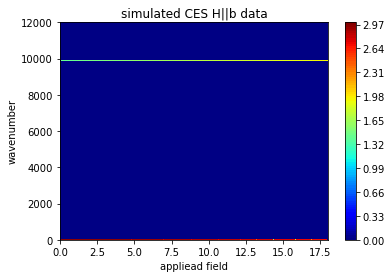

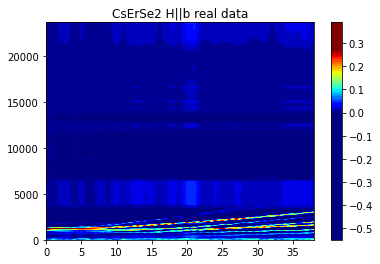

In [377]:
# result
fieldArr = np.linspace(0,18,50)
wavenums= np.linspace(0,12000,2400)

arr = fun(fieldArr, wavenums, result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5])
arr = np.array(arr)
plt.contourf(fieldArr,wavenums,arr.T, 100, cmap='jet')
# plt.xlim(7.5,10)
# plt.ylim(500,1000)
# plt.clim(0,.5)
plt.title('simulated CES H||b data')
plt.xlabel('appliead field')
plt.ylabel('wavenumber')
plt.colorbar()


plt.figure()
plt.contourf( fullData,100, cmap ='jet')
# plt.xlim(0,17.5)
# plt.ylim(0,120)
plt.clim(0,.27)
plt.colorbar()
plt.title('CsErSe2 H||b real data')

# now lets do the c axis!!!

very important note: for some reason load 2 is a duplicate of load 1. 

find the H||C data. only calculations shown below :(

In [201]:

fname2 = '/Users/hopeless/Desktop/LeeLab/data/Maglab_IRMeasurement_June2022/ProcessingCode/Load2_TrimData/P3_CsEr_100_RAWAVG.dat'

rawData = pd.read_csv(fname, index_col=0, skiprows=0, header=1)
normData = rawData.dropna(axis = 0)
normData = normData.dropna(axis=1)
normData = normData.drop(labels = '-1.1', axis=1)

In [202]:

normSpec = rawData['0.001']/max(rawData['0.001'])
avgSpec = rawData['0.001']/max(rawData['0.001']) 
for column in normData.columns: 
    # in a dataframe, column is a key
    normData[column] = normData[column]/(max(normData[column])+.01) -normSpec +0.1
    avgSpec += normData[column]

In [203]:
len(rawData.columns)
for column in normData.columns: 
    normData[column] = normData[column]-avgSpec/len(rawData.columns)
    normData[column] = 1-normData[column]
    # normData[column] = normData[column]/max(normData[column]+0.01)+0.01
normData = normData.drop(labels='0.001', axis=1)

In [204]:
# plt.contourf(Bfield, wavenums, normData, 100)
# plt.ylim(0, 120)
# # plt.clim(.4,.97)
# plt.colorbar()

In [205]:
def dummyModelC(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield)
    # I still don't understand why its just calcA... figure this out...
    return calcC.T


In [206]:

guessLines = dummyModelC(resultB.x[0], resultB.x[1], resultB.x[2], resultB.x[3], resultB.x[4], resultB.x[5])
# plt.contourf( wavenums, Bfield,normData.T,200, cmap = 'jet')
plotCalcZSpec(guessLines, Bfield)
plt.xlim(0,120)
plt.xlabel('wavenumber')
plt.ylabel('field')
# plt.clim(.93, 1)
# plt.colorbar()
plt.title('calculated lines for CsErSe2 H||c')

TypeError: zeemanSplit() missing 5 required positional arguments: 'B40', 'B43', 'B60', 'B63', and 'B66'

In [ ]:
# plt.contourf(Bfield, wavenums, newCalcData,200)
# # plotCalcZSpec(calcLines, Bfield)
# plt.ylim(0,200)
# plt.clim(.6, 1)
# plt.colorbar()

In [ ]:
plt.plot(